In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
df = pd.read_csv("QueryResults.csv")
df.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,11,1655,205591,NaN,42
1,"Message ""Support for password authentication w...",<p>I got this error on my console when I tried...,<git><github><github-api><git-pull><personal-a...,68775869,1809,2439560,NaN,53
2,How to get first N number of elements from an ...,<p>I am working with Javascript(ES6) /FaceBook...,<javascript><arrays><filtering><slice><extract>,34883068,1206,1420494,NaN,13
3,"Git is not working after macOS update (""xcrun:...","<p>I updated to the latest OS, and/or restarte...",<xcode><git><macos><command-line><terminal>,52522565,3509,1500843,NaN,41
4,How do I copy a folder from remote to local us...,<p>How do I copy a folder from remote to local...,<shell><ssh><command-line><copy><scp>,11304895,3573,3778083,NaN,17


In [2]:
# Statistiques descriptives
df[['Score', 'ViewCount', 'FavoriteCount', 'AnswerCount']].describe()

,Score,ViewCount,FavoriteCount,AnswerCount
count,359.000000,3.590000e+02,0.0,359.000000
mean,2322.061281,1.693753e+06,NaN,29.178273
std,2259.858566,1.547658e+06,NaN,18.262257
min,1001.000000,1.456010e+05,NaN,10.000000
25%,1232.000000,7.407650e+05,NaN,16.000000
50%,1611.000000,1.235701e+06,NaN,26.000000
75%,2523.000000,2.198862e+06,NaN,35.000000
max,27456.000000,1.281467e+07,NaN,132.000000


Text(0.5, 1.0, 'Distribution des Scores')

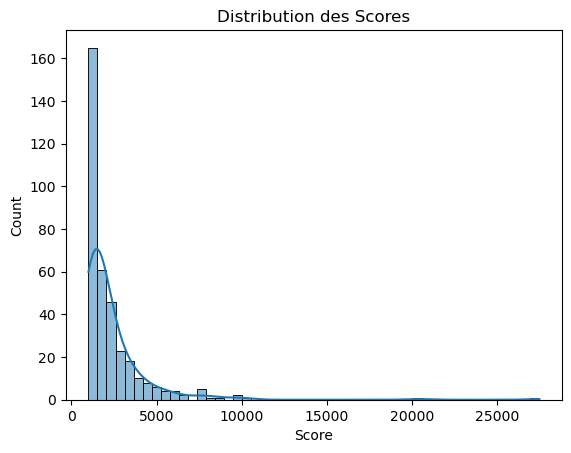

In [3]:
# Distribution des scores
sns.histplot(df['Score'], bins=50, kde=True)
plt.title("Distribution des Scores")

In [4]:
# Questions avec les scores les plus élevés
top_scores = df.sort_values('Score', ascending=False).head(10)
print("Top 10 questions avec le score le plus élevé :")
print(top_scores[['Title', 'Score']])

Top 10 questions avec le score le plus élevé :
                                                 Title  Score
357  Why is processing a sorted array faster than p...  27456
251  How do I delete a Git branch locally and remot...  20365
241               What is the '-->' operator in C/C++?  10232
213  How do I force "git pull" to overwrite local f...   9893
67              What and where are the stack and heap?   9538
122  How do I check if an element is hidden in jQuery?   8740
155           What does if __name__ == "__main__": do?   8386
43     Is Java "pass-by-reference" or "pass-by-value"?   7745
70   Find all files containing a specific text (str...   7680
93                    How do JavaScript closures work?   7611


In [5]:
# Questions les plus vues
top_views = df.sort_values('ViewCount', ascending=False).head(10)
print("Top 10 questions les plus vues :")
print(top_views[['Title', 'ViewCount']])

Top 10 questions les plus vues :
                                                 Title  ViewCount
251  How do I delete a Git branch locally and remot...   12814667
70   Find all files containing a specific text (str...   11841905
213  How do I force "git pull" to overwrite local f...    9267819
9                      Renaming column names in Pandas    6919751
303  How do I check if a string contains a specific...    6832157
72   How do I select rows from a DataFrame based on...    6807496
272  How do I push a new local branch to a remote G...    6620214
96   Why does my JavaScript code receive a "No 'Acc...    6533367
144  How do I change the size of figures drawn with...    6328679
259       How do I UPDATE from a SELECT in SQL Server?    5563301


Text(0.5, 1.0, 'Corrélation entre les variables')

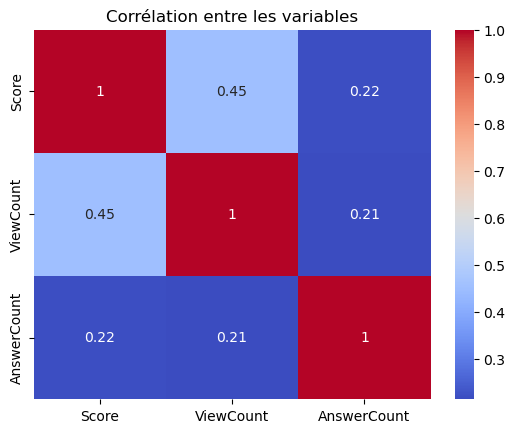

In [6]:
# Analyse multivariée : Corrélation entre les variables numériques
sns.heatmap(df[['Score', 'ViewCount', 'AnswerCount']].corr(), annot=True, cmap="coolwarm")
plt.title("Corrélation entre les variables")

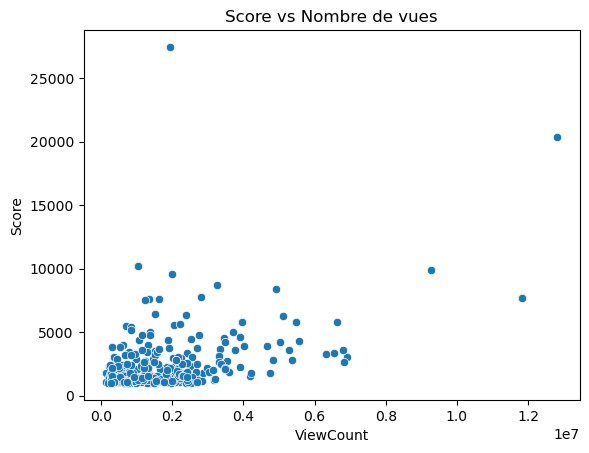

In [7]:
# Scatter plot : Score vs ViewCount
sns.scatterplot(x='ViewCount', y='Score', data=df)
plt.title("Score vs Nombre de vues")
plt.show()

In [8]:
import re
from bs4 import BeautifulSoup
import spacy

# Charger le modèle spaCy anglais
nlp = spacy.load("en_core_web_sm")

In [9]:
def clean_text_spacy(text, remove_code=False):
    if not isinstance(text, str):
        return ""
    
    # Supprimer les balises <code>...</code> si demandé
    if remove_code:
        text = re.sub(r'<code>.*?</code>', '', text, flags=re.DOTALL)
    
    # Supprimer les balises HTML restantes
    try:
        if "<" in text and ">" in text:
            text = BeautifulSoup(text, "html.parser").get_text()
    except Exception:
        pass

    # Utiliser spaCy pour le traitement linguistique
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space
    ]
    
    return ' '.join(tokens)

# Application sur les colonnes du DataFrame
df['CleanTitle'] = df['Title'].apply(clean_text_spacy)
df['CleanBody'] = df['Body'].apply(lambda x: clean_text_spacy(x, remove_code=True))
df['Text'] = df['CleanTitle'] + ' ' + df['CleanBody']

In [10]:
# Feature engineering
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=10000)
X_bow = vectorizer.fit_transform(df['Text'])

In [11]:
# Réduction de dimension
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100)
X_reduced = svd.fit_transform(X_bow)

In [12]:
# Préparation des cibles (Tags)
from sklearn.preprocessing import MultiLabelBinarizer

df['TagList'] = df['Tags'].apply(lambda x: re.findall(r'<(.*?)>', x))
mlb = MultiLabelBinarizer()
Y_tags = mlb.fit_transform(df['TagList'])